## 1. Setup del Notebook

### 1.1 Importación de Librerias

In [1]:
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    OneHotEncoder
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    HuberRegressor
)

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

### 1.2 Lectura de Archivos

In [3]:
df = pd.read_csv("../../data/features/dentix_model_input.csv")
df.head()

,TRANSACTION ID,NO PERSONAS A CARGO,ANTIGUEDAD EN LA CIUDAD tiempo en residencia,ESTRATO,INGRESOS FIJOS,TOTAL INGRESOS,CUOTA DE CREDITOS,GASTOS DE SOSTENIMIENTO,TOTAL EGRESOS,ACTIVOS,PASIVOS,MONTO PREAPROBADO,NO CREDITO,MONTO APROBADO,PLAZO,MONTO DESEMBOLSO,IDENTIFICACION COMERCIAL,TASA,CUOTAMENSUAL,CODIGO CIIU,OPERACION MONEDA EXTRAGERA,SCORE,SEGURO,AVAL,CODIGO CONFIRMACION CREDITO,PAGARE_ID,NUMERO CREDITO TESEO,SALDO CAPITAL,SALDO VENCIDO,DIAS DE MORA,FRANJA DE MORA,SALDO VENCIDO_LOG,DIAS DE MORA _LOG,TOTAL INGRESOS_LOG,INGRESOS FIJOS_LOG,MONTO APROBADO_LOG,MONTO PREAPROBADO_LOG,PASIVOS_LOG,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO PREAPROBADO_YJ,MONTO APROBADO_YJ,MONTO DESEMBOLSO_YJ,SEGURO_YJ,AVAL_YJ,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,INCIDENCIAFORMALIZACION_Albania,INCIDENCIAFORMALIZACION_Argentina,INCIDENCIAFORMALIZACION_Armenia,INCIDENCIAFORMALIZACION_Belgica,INCIDENCIAFORMALIZACION_China,"INCIDENCIAFORMALIZACION_Cocos (Keeling), Islas",INCIDENCIAFORMALIZACION_Colombia,INCIDENCIAFORMALIZACION_Ecuador,INCIDENCIAFORMALIZACION_España,INCIDENCIAFORMALIZACION_Estados Unidos,INCIDENCIAFORMALIZACION_Honduras,INCIDENCIAFORMALIZACION_Italia,INCIDENCIAFORMALIZACION_Mexico,INCIDENCIAFORMALIZACION_Panama,INCIDENCIAFORMALIZACION_Puerto Rico,INCIDENCIAFORMALIZACION_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Denti

## 2. Preparación de Datos

### 2.1 Comprensión inicial

In [4]:
yj_cols = [col for col in df.columns if col.endswith("_YJ")]

onehot_cols = df.select_dtypes(include=['bool']).columns.tolist()

other_cols = ['TRANSACTION ID', 'ESTRATO', 'SCORE', 'CUOTA DE CREDITOS',
              'TOTAL EGRESOS', 'ACTIVOS', 'PLAZO', 'TASA', 'CUOTAMENSUAL',
              'NIVEL ESTUDIOS_ORD', 'PROFESION_FREQ', 'CIUDAD_FREQ',
              'COMERCIAL_FREQ', 'DEPARTAMENTO_FREQ']

cols_finales = yj_cols + onehot_cols + other_cols

df0 = df[cols_finales].copy()
df0 = df0.set_index("TRANSACTION ID")

pattern = re.compile(r"^INCIDENCIA[\s_]*FORMALIZACION", re.IGNORECASE)

cols_to_drop = [c for c in df0.columns if pattern.search(c)]
print("A borrar:", cols_to_drop)

if not cols_to_drop:
    pattern2 = re.compile(r"^INCIDENCIA[\s_]*FORMALIZACION.*_YJ$", re.IGNORECASE)
    cols_to_drop = [c for c in df_yj_onehot.columns if pattern2.search(c)]
    print("Variante _YJ a borrar:", cols_to_drop)

df0 = df0.drop(columns=cols_to_drop)
df0.head()

A borrar: ['INCIDENCIAFORMALIZACION_Albania', 'INCIDENCIAFORMALIZACION_Argentina', 'INCIDENCIAFORMALIZACION_Armenia', 'INCIDENCIAFORMALIZACION_Belgica', 'INCIDENCIAFORMALIZACION_China', 'INCIDENCIAFORMALIZACION_Cocos (Keeling), Islas', 'INCIDENCIAFORMALIZACION_Colombia', 'INCIDENCIAFORMALIZACION_Ecuador', 'INCIDENCIAFORMALIZACION_España', 'INCIDENCIAFORMALIZACION_Estados Unidos', 'INCIDENCIAFORMALIZACION_Honduras', 'INCIDENCIAFORMALIZACION_Italia', 'INCIDENCIAFORMALIZACION_Mexico', 'INCIDENCIAFORMALIZACION_Panama', 'INCIDENCIAFORMALIZACION_Puerto Rico', 'INCIDENCIAFORMALIZACION_Venezuela']


,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO PREAPROBADO_YJ,MONTO APROBADO_YJ,MONTO DESEMBOLSO_YJ,SEGURO_YJ,AVAL_YJ,OPERACION MONEDA EXTRAGERA,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Dentix MDE Av. Poblado Medellín,CLINICA_Dentix MDE Envigado,CLINICA_Dentix MDE Fabricato Multialiado,CLINICA_Dentix MDE Itagüi Mayorca,CLINICA_Dentix MTR Montería,CLINICA_Dentix MZL Cra. 23 Manizales,CLINICA_Dentix NVA Neiva,CLINICA_Dentix PEI Pereira,CLINICA_Dentix PPN Popayán,CLINICA_Dentix PPN Popayán Campanario,CLINICA_Dentix PSO Pasto,CLINICA_Dentix SMR Santa Marta,CLINICA_Dentix TUN Tunja,CLINICA_Dentix VUP Valledupar,CLINICA_Dentix VVC Primavera Villavicencio,ESTRATO,SCORE,CUOTA DE CREDITOS,TOTAL EGRESOS,ACTIVOS,PLAZO,TASA,CUOTAMENSUAL,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ
TRANSACTION ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016918,1.550697,1.659905,-1.342884,2.274419,2.274626,2.274398,2.274323,2.172652,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

### 2.2 Supuestos de Regresión

#### 2.2.1 Linealidad

La relación entre la variable dependiente (MONTO APROBADO) y los predictores debe ser lineal en los parámetros.

In [5]:
features = df0.select_dtypes(include=['int', 'float'])
features

,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO PREAPROBADO_YJ,MONTO APROBADO_YJ,MONTO DESEMBOLSO_YJ,SEGURO_YJ,AVAL_YJ,ESTRATO,SCORE,CUOTA DE CREDITOS,TOTAL EGRESOS,ACTIVOS,PLAZO,TASA,CUOTAMENSUAL,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ
TRANSACTION ID,,,,,,,,,,,,,,,,,,,,,
2016918,1.550697,1.659905,-1.342884,2.274419,2.274626,2.274398,2.274323,2.172652,1.596071,-0.497084,-0.008909,-0.009082,1.683621,36,0.171785,-0.193257,0.842079,0.220835,-0.542495,0.977167,-0.442162
2016914,1.910448,1.884618,-2.106196,0.587438,0.587502,0.587471,0.587420,0.935561,0.631589,1.450843,-0.008914,-0.009089,-0.846057,36,0.171785,-0.193264,-0.995517,-0.348914,-0.795561,1.627940,-0.505167
2016836,-1.610168,-3.012882,0.926897,-1.333679,-1.333696,-1.333657,-1.333466,-0.703152,-0.332892,-0.687861,-0.008914,-0.009020,-0.737642,18,0.171785,-0.193267,-0.995517,-0.931155,1.518785,-0.584690,1.470026
2016736,0.101804,0.675282,1.123095,-0.430452,-0.430443,-0.430414,-0.430477,0.103713,0.631589,0.557206,-0.008877,-0.008977,-0.846057,36,0.171785,-0.193266,-0.995517,-0.495017,-0.450153,1.003198,-0.565021
2016576,1.753045,1.696270,-1.094328,-0.835670,-0.835676,-0.835637,-0.835645,-0.249351,0.631589,-1.963050,-0.008904,-0.009076,-0.846057,36,0.171785,-0.193267,0.842079,0.220835,-0.445501,2.651824,-0.505167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047579,0.101804,-0.468450,0.694852,-0.955496,-0.955505,-0.955464,-0.955695,-0.356493,0.631589,1.922764,-0.008914,-0.009034,-0.846057,12,0.131465,-0.193265,-0.995517,1.392377,-0.450153,1.593232,-0.565021
2047954,-0.458372,-1.270907,0.694852,0.644273,0.644340,0.644304,0.644305,0.979841,0.631589,-0.717983,-0.008914,-0.009034,-0.846057,30,0.131465,-0.193263,-0.995517,-0.807863,-0.450153,1.593232,-0.565021
2047975,1.691614,1.621816,0.027407,0.310836,0.310882,0.310872,0.310945,0.716695,-1.297374,-0.236022,-0.008910,-0.009059,-0.701504,30,0.131465,-0.193264,-0.382985,-0.495017,1.518785,0.152854,1.470026


In [6]:
corr_target = features.corr()["MONTO APROBADO_YJ"].sort_values(ascending=False)
corr_target

MONTO APROBADO_YJ             1.000000
MONTO PREAPROBADO_YJ          0.999971
MONTO DESEMBOLSO_YJ           0.999958
SEGURO_YJ                     0.999954
AVAL_YJ                       0.893320
PLAZO                         0.371699
INGRESOS FIJOS_YJ             0.319222
TOTAL INGRESOS_YJ             0.297824
COMERCIAL_FREQ                0.107530
ESTRATO                       0.102229
ACTIVOS                       0.094756
CUOTAMENSUAL                  0.092646
NIVEL ESTUDIOS_ORD            0.058710
TASA                          0.037246
PROFESION_FREQ                0.020670
CIUDAD_FREQ                   0.009115
DEPARTAMENTO_FREQ             0.007577
CUOTA DE CREDITOS             0.001919
TOTAL EGRESOS                 0.001893
SCORE                        -0.017746
GASTOS DE SOSTENIMIENTO_YJ   -0.036002
Name: MONTO APROBADO_YJ, dtype: float64

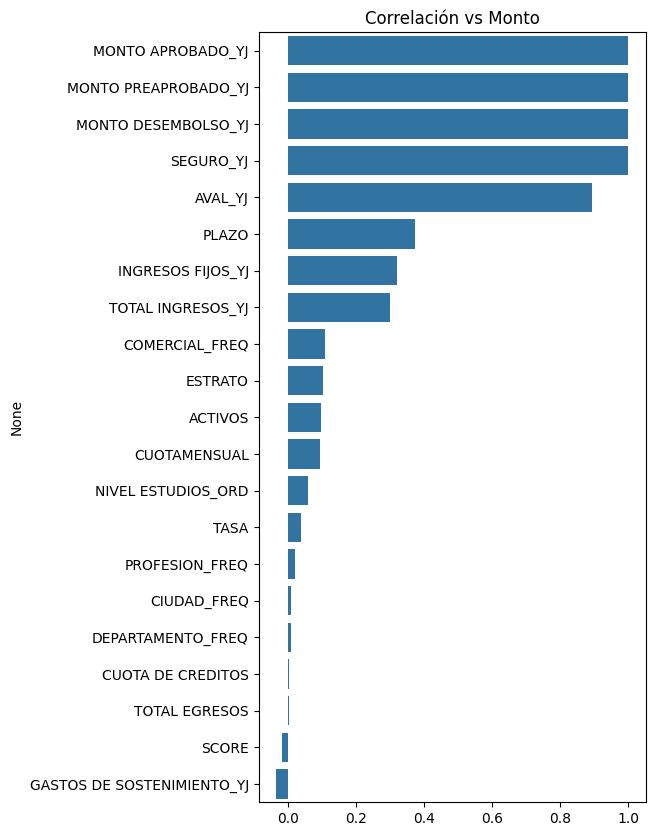

In [7]:
plt.figure(figsize=(5,10))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlación vs Monto")
plt.show()

#### 2.2.2 Independencia de los Errores

Los residuos deben ser independientes entre sí; es decir, el error de una observación no afecta al siguiente.

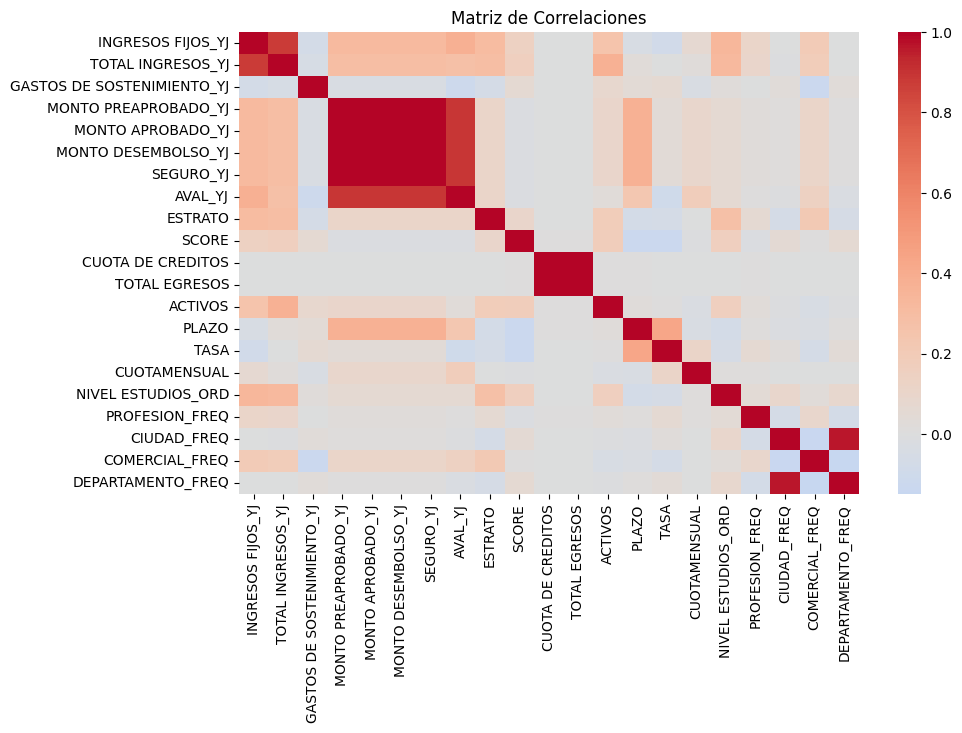

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(features.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de Correlaciones")
plt.show()

In [9]:
to_drop = [
    "MONTO APROBADO", 
    "MONTO APROBADO_LOG",
    "MONTO PREAPROBADO", 
    "MONTO PREAPROBADO_YJ",
    "MONTO DESEMBOLSO", 
    "MONTO DESEMBOLSO_YJ",
    "DESEMBOLSO",
    "SEGURO_YJ",
    "AVAL_YJ"
]

df_clean = df0.drop(columns=[c for c in to_drop if c in df0.columns])
df_clean.head()

,INGRESOS FIJOS_YJ,TOTAL INGRESOS_YJ,GASTOS DE SOSTENIMIENTO_YJ,MONTO APROBADO_YJ,OPERACION MONEDA EXTRAGERA,ESTADOCIVIL_Divorciado (a) / Separado (a),ESTADOCIVIL_Soltero (a),ESTADOCIVIL_Unión libre,ESTADOCIVIL_Viudo (a),TIPO VIVIENDA_Familiar,TIPO VIVIENDA_Propia,TIPO VIVIENDA_Propia con crédito,ACTIVIDAD ECONÓMICA_Actividades de apoyo a la educación.,ACTIVIDAD ECONÓMICA_Actividades no diferenciadas de los hogares individuales como productores de bienes para uso propio.,ACTIVIDAD ECONÓMICA_Asalariados,ACTIVIDAD ECONÓMICA_Comercio al por mayor a cambio de una retribución o por contrata.,ACTIVIDAD ECONÓMICA_Otras actividades de servicios personales n.c.p.,"ACTIVIDAD ECONÓMICA_Otros tipos de comercio al por menor no realizado en establecimientos, puestos de venta o mercados.",ACTIVIDAD ECONÓMICA_Pensionados,"ACTIVIDAD ECONÓMICA_Rentistas de Capital, solo para personas naturales.",TIPO CONTRATO_Indefinido,TIPO CONTRATO_No Aplica,TIPO CONTRATO_Prestación de servicios,OCUPACIÓN_Empleado,OCUPACIÓN_Estudiante,OCUPACIÓN_Independiente,OCUPACIÓN_Pensionado / Jubilado,OCUPACIÓN_Rentista,OCUPACIÓN_Taxista,OCUPACIÓN_Vendedora por catalogo,LUGAR NACIMIENTO_Albania,LUGAR NACIMIENTO_Argentina,LUGAR NACIMIENTO_Armenia,LUGAR NACIMIENTO_Belgica,LUGAR NACIMIENTO_China,"LUGAR NACIMIENTO_Cocos (Keeling), Islas",LUGAR NACIMIENTO_Colombia,LUGAR NACIMIENTO_Ecuador,LUGAR NACIMIENTO_España,LUGAR NACIMIENTO_Estados Unidos,LUGAR NACIMIENTO_Honduras,LUGAR NACIMIENTO_Italia,LUGAR NACIMIENTO_Mexico,LUGAR NACIMIENTO_Panama,LUGAR NACIMIENTO_Puerto Rico,LUGAR NACIMIENTO_Venezuela,CLINICA_Dentix BAQ Barranquilla,CLINICA_Dentix BAQ Barranquilla Portal del Prado,CLINICA_Dentix BGA Cañaveral,CLINICA_Dentix BGA Cl 35 Bucaramanga,CLINICA_Dentix BOG Andino,CLINICA_Dentix BOG Autopista 104A Bogota,CLINICA_Dentix BOG Avenida Chile,CLINICA_Dentix BOG C. C. Plaza Central,CLINICA_Dentix BOG C.C. Titan,CLINICA_Dentix BOG CC Plaza de las Américas Bogotá,CLINICA_Dentix BOG Calle 90,CLINICA_Dentix BOG Cedritos - Bogotá,CLINICA_Dentix BOG Chapinero,CLINICA_Dentix BOG Chia,CLINICA_Dentix BOG Colina Bogotá,CLINICA_Dentix BOG Diverplaza,CLINICA_Dentix BOG Fontibon,CLINICA_Dentix BOG Galerias,CLINICA_Dentix BOG Gran Estación,CLINICA_Dentix BOG Hayuelos,CLINICA_Dentix BOG Plaza Imperial,CLINICA_Dentix BOG Restrepo,CLINICA_Dentix BOG Santa Fe,CLINICA_Dentix BOG Unicentro,CLINICA_Dentix BOG Usaquen,CLINICA_Dentix BOG Venecia,CLINICA_Dentix CLO Av. 100 Cali,CLINICA_Dentix CLO Cali Chipichape,CLINICA_Dentix CLO Imbanaco,CLINICA_Dentix CLO Tulua,CLINICA_Dentix CTG Cartagena Cc Mallplaza,CLINICA_Dentix CUC Calle 13 Cúcuta,CLINICA_Dentix EOH Bello,CLINICA_Dentix EOH Centro Medellín,CLINICA_Dentix EOH Nutibara Medellin,CLINICA_Dentix IBE Cra. 5 Ibague,CLINICA_Dentix MDE Av. Poblado Medellín,CLINICA_Dentix MDE Envigado,CLINICA_Dentix MDE Fabricato Multialiado,CLINICA_Dentix MDE Itagüi Mayorca,CLINICA_Dentix MTR Montería,CLINICA_Dentix MZL Cra. 23 Manizales,CLINICA_Dentix NVA Neiva,CLINICA_Dentix PEI Pereira,CLINICA_Dentix PPN Popayán,CLINICA_Dentix PPN Popayán Campanario,CLINICA_Dentix PSO Pasto,CLINICA_Dentix SMR Santa Marta,CLINICA_Dentix TUN Tunja,CLINICA_Dentix VUP Valledupar,CLINICA_Dentix VVC Primavera Villavicencio,ESTRATO,SCORE,CUOTA DE CREDITOS,TOTAL EGRESOS,ACTIVOS,PLAZO,TASA,CUOTAMENSUAL,NIVEL ESTUDIOS_ORD,PROFESION_FREQ,CIUDAD_FREQ,COMERCIAL_FREQ,DEPARTAMENTO_FREQ
TRANSACTION ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016918,1.550697,1.659905,-1.342884,2.274626,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [10]:
df_num = df_clean.select_dtypes(include=['int64','float64'])
corr_target = df_num.corr()["MONTO APROBADO_YJ"].sort_values(ascending=False)
corr_target

MONTO APROBADO_YJ             1.000000
PLAZO                         0.371699
INGRESOS FIJOS_YJ             0.319222
TOTAL INGRESOS_YJ             0.297824
COMERCIAL_FREQ                0.107530
ESTRATO                       0.102229
ACTIVOS                       0.094756
CUOTAMENSUAL                  0.092646
NIVEL ESTUDIOS_ORD            0.058710
TASA                          0.037246
PROFESION_FREQ                0.020670
CIUDAD_FREQ                   0.009115
DEPARTAMENTO_FREQ             0.007577
CUOTA DE CREDITOS             0.001919
TOTAL EGRESOS                 0.001893
SCORE                        -0.017746
GASTOS DE SOSTENIMIENTO_YJ   -0.036002
Name: MONTO APROBADO_YJ, dtype: float64

In [11]:
X_vif = df_clean.drop(columns=["MONTO APROBADO_YJ"])
X_vif = X_vif.select_dtypes(include=['int64', 'float64']).copy()

vif = pd.DataFrame()
vif["Variable"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif.sort_values("VIF", ascending=False)

,Variable,VIF
6,TOTAL EGRESOS,4.897123e+07
5,CUOTA DE CREDITOS,4.897115e+07
13,CIUDAD_FREQ,1.374417e+01
15,DEPARTAMENTO_FREQ,1.373554e+01
0,INGRESOS FIJOS_YJ,5.772931e+00
1,TOTAL INGRESOS_YJ,5.672125e+00
7,ACTIVOS,1.254160e+00
11,NIVEL ESTUDIOS_ORD,1.218255e+00
3,ESTRATO,1.213217e+00
9,TASA,1.160808e+00


##### Modelo OLS preliminar

In [12]:
df_reg = df_clean.drop(columns=["TOTAL EGRESOS"], errors="ignore")

y_ols = df_reg["MONTO APROBADO_YJ"]
X_ols = df_reg.drop(columns=["MONTO APROBADO_YJ"])
X_ols = X_ols.select_dtypes(include=['float64','int64'])
X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y_ols, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      MONTO APROBADO_YJ   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     887.4
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:52:38   Log-Likelihood:                -42843.
No. Observations:               34156   AIC:                         8.572e+04
Df Residuals:                   34140   BIC:                         8.585e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [13]:
resid = ols_model.resid
fitted = ols_model.fittedvalues

#### 2.2.3 Homocedasticidad

La varianza de los residuos debe ser constante para todos los valores predichos.

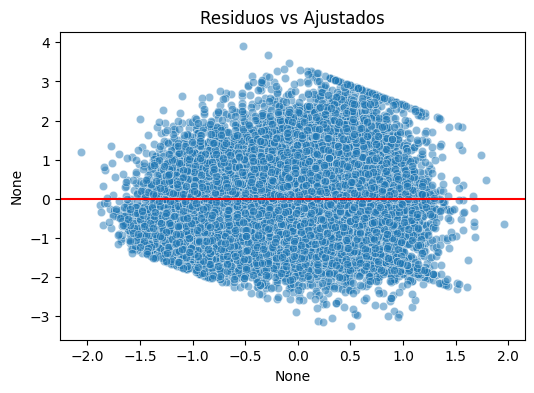

{'LM': np.float64(923.2723927650788),
 'LM p-val': np.float64(3.680513492452077e-187),
 'F': np.float64(63.231883665060415),
 'F p-val': np.float64(7.956711887789362e-190)}

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=resid, alpha=0.5)
plt.axhline(0, color='red')
plt.title("Residuos vs Ajustados")
plt.show()

from statsmodels.stats.diagnostic import het_breuschpagan
bp = het_breuschpagan(resid, X_ols)
labels = ["LM", "LM p-val", "F", "F p-val"]
dict(zip(labels, bp))

#### 2.2.4 Normalidad de los Errores

Los residuos deben seguir una distribución normal para que las inferencias sobre los coeficientes sean válidas.

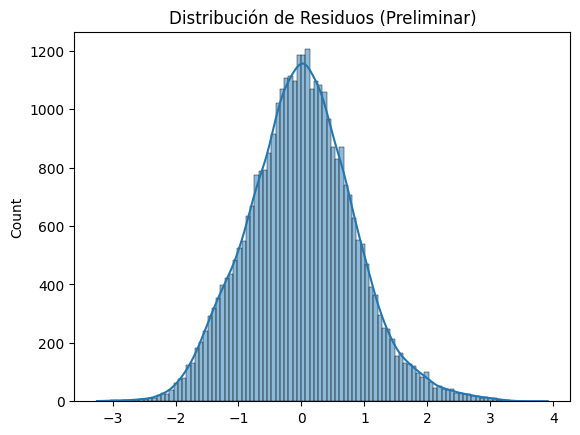

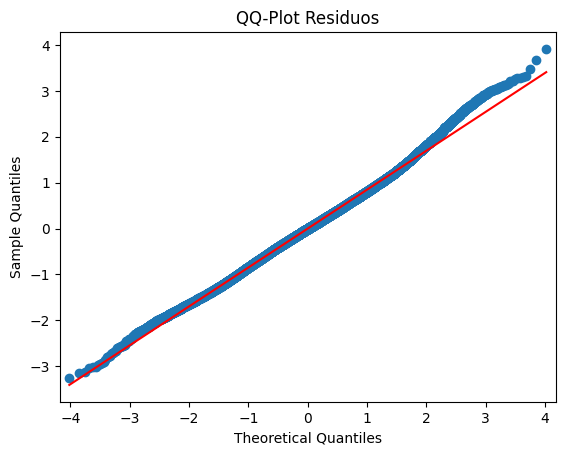

Shapiro–Wilk p-value: 5.498579397114299e-25


In [15]:
sns.histplot(resid, kde=True)
plt.title("Distribución de Residuos (Preliminar)")
plt.show()

sm.qqplot(resid, line="s")
plt.title("QQ-Plot Residuos")
plt.show()

from scipy.stats import shapiro
stat, p = shapiro(resid)
print("Shapiro–Wilk p-value:", p)


### 3. División de Datos

In [16]:
df_fechas = pd.read_excel("../../data/raw/BaseDentix.xlsx")
cols_keep = ["TRANSACTION ID", "FECHA SOLICITUD"]
df_fechas = df_fechas[cols_keep].copy()

In [17]:
id_col = "TRANSACTION ID"
fecha_col = "FECHA SOLICITUD"

df_merged = df_clean.merge(
    df_fechas,
    on=id_col,
    how="inner"
)

In [18]:
cols_to_drop = [
    'CUOTA DE CREDITOS', 'TOTAL EGRESOS' # 'PLAZO', 'TASA', 'CUOTAMENSUAL', 
    
]
df_merged = df_merged.drop(columns = cols_to_drop)
df_merged = df_merged.dropna(subset=[fecha_col])

In [19]:
df_merged[fecha_col] = pd.to_datetime(df_merged[fecha_col], errors="coerce")
df_merged = df_merged.sort_values(fecha_col).reset_index(drop=True)


In [20]:
split = int(len(df_merged) * 0.8)

train = df_merged.iloc[:split].copy()
test  = df_merged.iloc[split:].copy()

print(train.shape, test.shape)

(27324, 110) (6832, 110)


In [21]:
target = "MONTO APROBADO_YJ"

datetime_cols = train.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
print("Columnas datetime:\n", datetime_cols)

X = df_merged.drop(columns = [target]).copy()

y_train = train[target]
y_test  = test[target]

X_train = train.drop(columns=[target] + datetime_cols)
X_test  = test.drop(columns=[target] + datetime_cols)


X_train_clean = X_train.drop(columns=["TRANSACTION ID"], errors="ignore")
X_test_clean  = X_test.drop(columns=["TRANSACTION ID"], errors="ignore")

feature_names = X_train_clean.columns

Columnas datetime:
 ['FECHA SOLICITUD']


## 4. Modelos

### 4.1 Regresión Lineal Base 

In [22]:
lin = LinearRegression()
lin.fit(X_train_clean, y_train)

y_pred_lin = lin.predict(X_test_clean)

### 4.2 Regresión Robusta (Huber)

In [23]:
huber = HuberRegressor()
huber.fit(X_train_clean, y_train)

y_pred_huber = huber.predict(X_test_clean)

### 4.3 Ridge / Lasso

In [24]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_clean, y_train)
y_pred_ridge = ridge.predict(X_test_clean)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_clean, y_train)
y_pred_lasso = lasso.predict(X_test_clean)

## 5. Métricas

In [25]:
def report_metrics(y_true, y_pred):
    print(f"MAE : {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):,.2f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

print("===== LINEAR =====")
report_metrics(y_test, y_pred_lin)

print("\n===== HUBER =====")
report_metrics(y_test, y_pred_huber)

print("\n===== RIDGE =====")
report_metrics(y_test, y_pred_ridge)

print("\n===== LASSO =====")
report_metrics(y_test, y_pred_lasso)


===== LINEAR =====
MAE : 0.75
RMSE: 0.94
R²  : 0.1934

===== HUBER =====
MAE : 0.75
RMSE: 0.95
R²  : 0.1826

===== RIDGE =====
MAE : 0.75
RMSE: 0.94
R²  : 0.1926

===== LASSO =====
MAE : 0.75
RMSE: 0.95
R²  : 0.1869


## 6. Diagnóstico Estadístico

### 6.1 Residuos

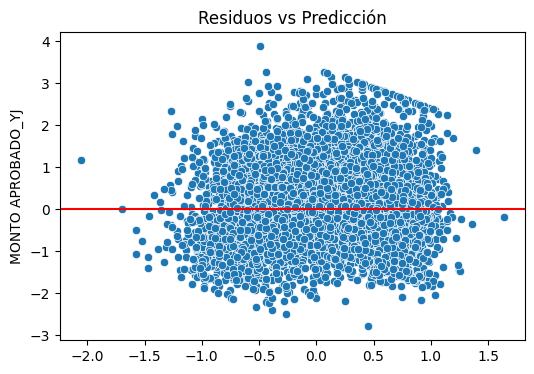

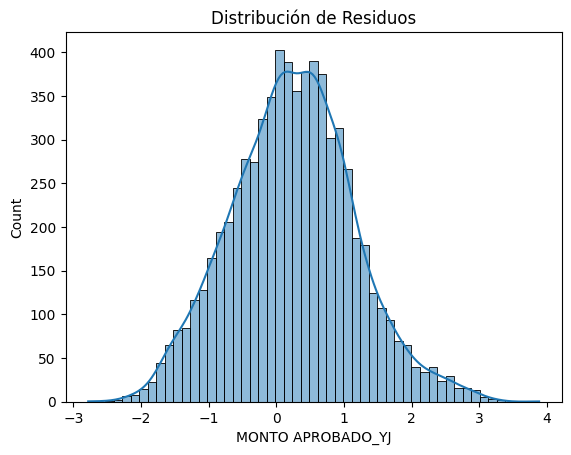

In [26]:
residuals = y_test - y_pred_lin

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_lin, y=residuals)
plt.axhline(0, color='red')
plt.title("Residuos vs Predicción")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Distribución de Residuos")
plt.show()

### 6.2 Test de Normalidad (Shapiro-Wilk)

In [27]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print("Shapiro-Wilk p-value:", p)

Shapiro-Wilk p-value: 1.8509893995231373e-09


### 6.3 Heterocedasticidad (Breusch-Pagan)

In [28]:
from statsmodels.stats.diagnostic import het_breuschpagan

exog = sm.add_constant(X_test_clean)
bp_test = het_breuschpagan(residuals, exog)

labels = ["LM Stat", "LM p-val", "F-stat", "F p-val"]
dict(zip(labels, bp_test))

{'LM Stat': np.float64(324.9384449187084),
 'LM p-val': np.float64(8.051944480190753e-24),
 'F-stat': np.float64(4.213997791240344),
 'F p-val': np.float64(3.063216855677643e-32)}

## 7. Interpretabilidad

### 7.1 Coeficientes

In [29]:
coef_df = pd.DataFrame({
    "Variable": X_test_clean.columns,
    "Coef": lin.coef_
}).sort_values(by="Coef", ascending=False)

coef_df.head(15)

,Variable,Coef
42,LUGAR NACIMIENTO_Panama,0.855102
38,LUGAR NACIMIENTO_Estados Unidos,0.556286
36,LUGAR NACIMIENTO_Ecuador,0.554639
32,LUGAR NACIMIENTO_Belgica,0.459502
27,OCUPACIÓN_Taxista,0.372875
30,LUGAR NACIMIENTO_Argentina,0.357169
43,LUGAR NACIMIENTO_Puerto Rico,0.317777
26,OCUPACIÓN_Rentista,0.303414
0,INGRESOS FIJOS_YJ,0.282612
25,OCUPACIÓN_Pensionado / Jubilado,0.270194


### 7.2 SHAP Values

In [30]:
explainer = shap.LinearExplainer(
    lin,
    X_train_clean,
    feature_perturbation="interventional"
)

shap_values = explainer(X_test_clean)

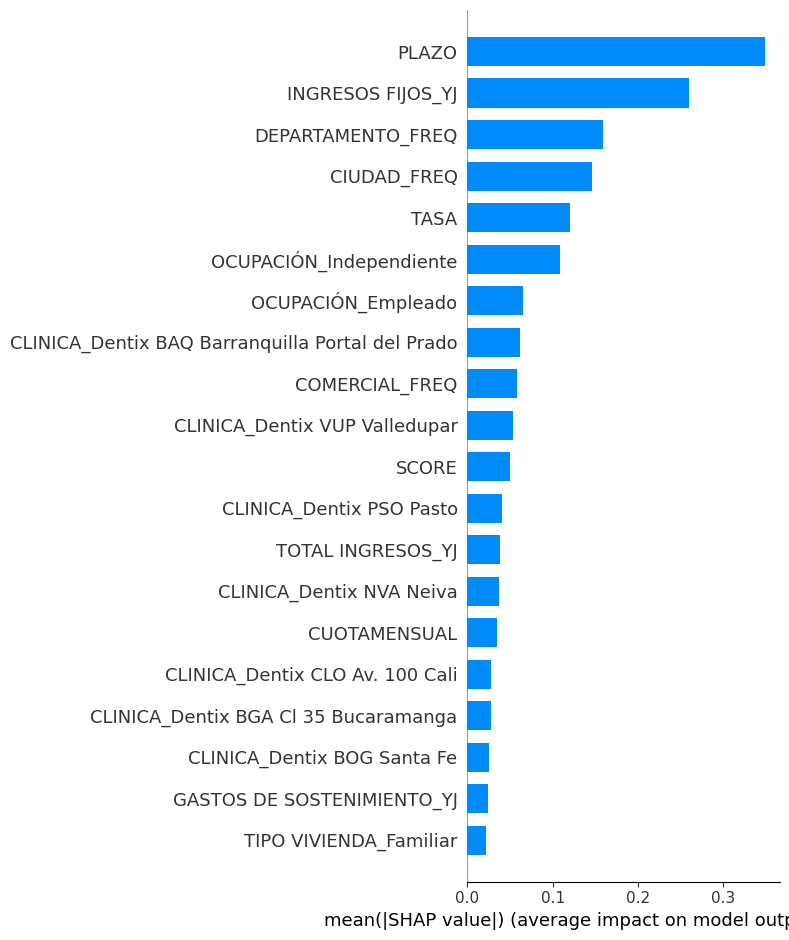

In [31]:
shap.summary_plot(
    shap_values, 
    X_test_clean,
    plot_type="bar"
)

## 8. Análisis por Clínica y Asesor

### 8.1 Error por Clínica / Asesor

In [32]:
clinic_cols = [col for col in df_merged.columns if col.startswith("CLINICA_")]

df_merged["CLINICA"] = df_merged[clinic_cols].idxmax(axis=1)

df_merged["CLINICA"] = df_merged["CLINICA"].str.replace("CLINICA_", "")

df_asesores = pd.read_csv("../../data/interim/04_outliers_cleaned.csv")
df_merged = df_merged.merge(
    df_asesores[['TRANSACTION ID', 'COMERCIAL']],
    on='TRANSACTION ID',
    how='left'
)

df_merged.index = X.index

In [33]:
df_results = df_merged.loc[y_test.index].copy()
df_results["pred"] = y_pred_lin
df_results["error"] = df_results[target] - df_results["pred"]
df_results["abs_error"] = df_results["error"].abs()

group_clinic = df_results.groupby("CLINICA").agg(
    MAE = ("abs_error", "mean"),
    RMSE = ("abs_error", lambda x: np.sqrt(np.mean(x**2))),
    R2 = (target, lambda y_cl: r2_score(
        y_cl,
        df_results.loc[y_cl.index, "pred"]
    )),
    count=("abs_error", "count"),
).sort_values("MAE", ascending=False)

group_clinic.head(10)

,MAE,RMSE,R2,count
CLINICA,,,,
Dentix BOG Calle 90,1.375795,1.375795,NaN,1
Dentix NVA Neiva,1.114254,1.321618,-0.597716,196
Dentix CLO Cali Chipichape,0.928617,1.169994,-0.304388,209
Dentix EOH Nutibara Medellin,0.872159,1.012361,0.263782,34
Dentix MZL Cra. 23 Manizales,0.827734,1.024925,0.273185,318
Dentix BOG Plaza Imperial,0.814340,1.026864,0.112823,311
Dentix BOG Santa Fe,0.809166,0.997411,0.233392,171
Dentix BOG Gran Estación,0.804082,0.994138,0.251009,108
Dentix BOG Unicentro,0.798798,1.039966,-0.185026,19


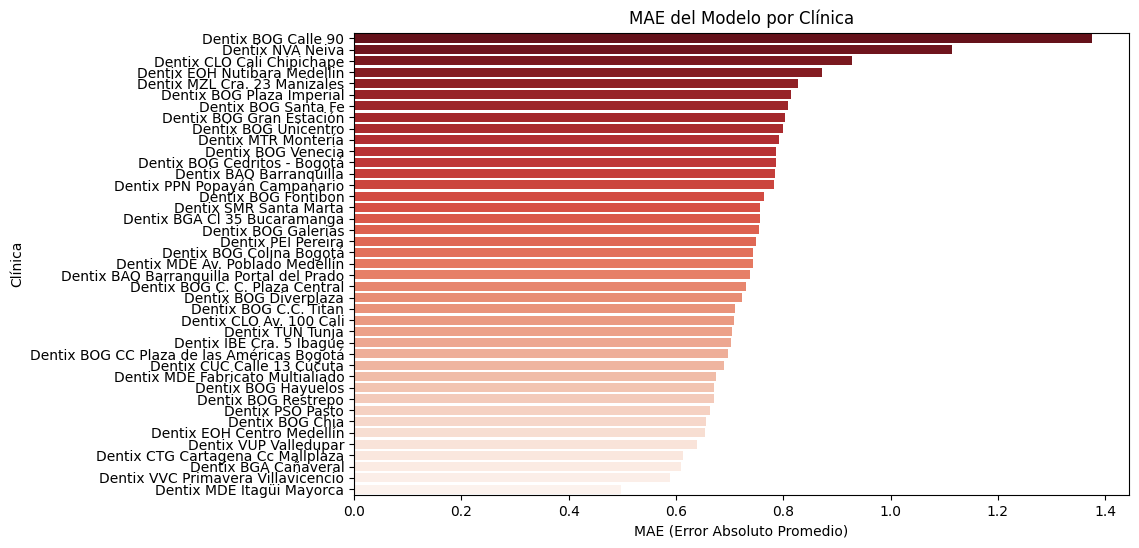

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=group_clinic.reset_index(), 
    x="MAE", y="CLINICA", palette="Reds_r"
)
plt.title("MAE del Modelo por Clínica")
plt.xlabel("MAE (Error Absoluto Promedio)")
plt.ylabel("Clínica")
plt.show()

### 8.3 Sesgo Sistemático por Clínica

In [35]:
clinic_bias = df_results.groupby("CLINICA")["error"].mean().sort_values()

clinic_bias

CLINICA
Dentix BOG Calle 90                          -1.375795
Dentix EOH Centro Medellín                   -0.059191
Dentix MTR Montería                          -0.011535
Dentix CTG Cartagena Cc Mallplaza            -0.007615
Dentix BOG C.C. Titan                         0.059760
Dentix MDE Av. Poblado Medellín               0.062377
Dentix EOH Nutibara Medellin                  0.070728
Dentix BOG Gran Estación                      0.074024
Dentix MDE Fabricato Multialiado              0.076797
Dentix BOG Hayuelos                           0.115780
Dentix VVC Primavera Villavicencio            0.116320
Dentix BOG CC Plaza de las Américas Bogotá    0.127144
Dentix BAQ Barranquilla Portal del Prado      0.134260
Dentix BOG C. C. Plaza Central                0.166317
Dentix TUN Tunja                              0.178514
Dentix PSO Pasto                              0.190815
Dentix IBE Cra. 5 Ibague                      0.221218
Dentix VUP Valledupar                         0.222519
De

### 8.4 Error por Asesor

In [36]:
group_asesor = df_results.groupby("COMERCIAL").agg(
    MAE=("abs_error", "mean"),
    RMSE=("abs_error", lambda x: np.sqrt(np.mean(x**2))),
    count=("abs_error", "count")
).sort_values("MAE", ascending=False)

In [37]:
group_asesor

,MAE,RMSE,count
COMERCIAL,,,
dentix_jcorchueloc,1.510056,1.510056,1
colte_ebermeo,1.353038,1.516749,83
colte_cmartinezo,1.291601,1.310776,3
dentix_sgaraya,1.138310,1.138310,1
dentix_alopezo,1.081836,1.375128,4
...,...,...,...
dentix_kmonroyb,0.163642,0.200339,3
dentix_mbocanegrat,0.103368,0.103368,1
dentix_emaldonadob,0.081499,0.081499,1


### 8.5 Asesores Ánomalos

In [38]:
asesores_filtrados = group_asesor[group_asesor["count"] >= 10]
asesores_filtrados

,MAE,RMSE,count
COMERCIAL,,,
colte_ebermeo,1.353038,1.516749,83
colte_ccyagonzalez,1.076271,1.241705,28
colte_ccdentixclo009,1.022056,1.232667,77
colte_ccdentixibe002,0.999419,1.147139,33
dentix_kangaritaq,0.980821,1.154245,21
...,...,...,...
dentix_mduquev,0.542598,0.652045,42
colte_ccljvargas,0.538265,0.596957,12
dentix_jgarzonb,0.531543,0.695704,10


In [39]:
asesores_filtrados[asesores_filtrados["MAE"] > asesores_filtrados["MAE"].mean() + 1*asesores_filtrados["MAE"].std()]

,MAE,RMSE,count
COMERCIAL,,,
colte_ebermeo,1.353038,1.516749,83
colte_ccyagonzalez,1.076271,1.241705,28
colte_ccdentixclo009,1.022056,1.232667,77
colte_ccdentixibe002,0.999419,1.147139,33
dentix_kangaritaq,0.980821,1.154245,21
dentix_ydazad,0.967772,1.121954,13
colte_ccdentixneiva004,0.947146,1.140003,36
colte_yayalaf,0.944028,1.211020,99
colte_dgarciab,0.931306,1.081459,51


### 8.6 Visualización — MAE por Asesor

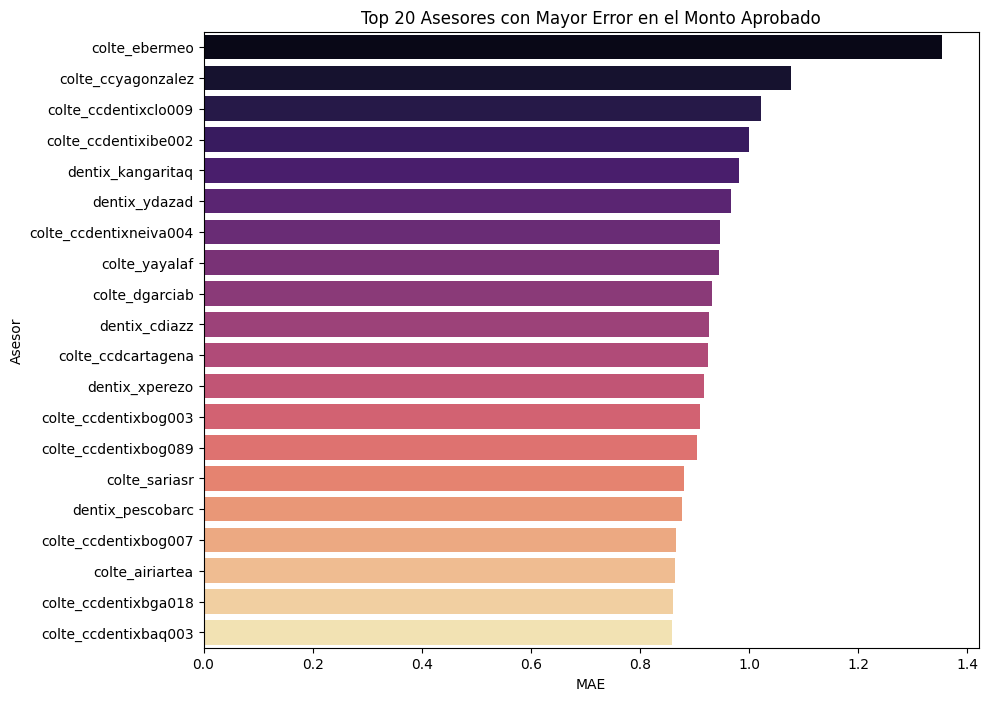

In [40]:
top_asesores = asesores_filtrados.sort_values("MAE", ascending=False).head(20)

plt.figure(figsize=(10,8))
sns.barplot(
    x=top_asesores["MAE"],
    y=top_asesores.index,
    palette="magma"
)
plt.title("Top 20 Asesores con Mayor Error en el Monto Aprobado")
plt.xlabel("MAE")
plt.ylabel("Asesor")
plt.show()

### 8.7 Evaluación de Heterogeneidad del Modelo por Clínica

In [41]:
clinic_r2 = df_results.groupby("CLINICA").apply(
    lambda g: r2_score(g[target], g["pred"])
).sort_values()

clinic_r2

CLINICA
Dentix NVA Neiva                             -0.597716
Dentix CLO Cali Chipichape                   -0.304388
Dentix BOG Unicentro                         -0.185026
Dentix CUC Calle 13 Cúcuta                   -0.122078
Dentix BOG Chia                              -0.075814
Dentix BGA Cañaveral                          0.015086
Dentix BAQ Barranquilla Portal del Prado      0.045114
Dentix MDE Av. Poblado Medellín               0.053914
Dentix BOG Fontibon                           0.075487
Dentix BOG C. C. Plaza Central                0.101053
Dentix BOG Restrepo                           0.101878
Dentix BOG Plaza Imperial                     0.112823
Dentix MDE Itagüi Mayorca                     0.131614
Dentix BAQ Barranquilla                       0.144753
Dentix BOG CC Plaza de las Américas Bogotá    0.148658
Dentix CLO Av. 100 Cali                       0.151172
Dentix BOG Galerias                           0.157105
Dentix VUP Valledupar                         0.162460
De